# Подключение гугл диска

In [1]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/3_year/WSI

/content/gdrive/MyDrive/3_year/WSI


# Установки и импорты

In [3]:
import sys
from pathlib import Path
sys.path.append('/content/gdrive/MyDrive/3_year/WSI/lexsubgen/')

In [4]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/MyDrive/3_year/WSI/lexsubgen/']

In [5]:
import importlib
import numpy as np
import pandas as pd
from itertools import product, combinations

In [6]:
from typing import Iterable, Dict, Union
import os

In [43]:
import warnings
  
warnings.filterwarnings('ignore')

# Кластеризация

In [7]:
# папки, где хранятся подстановки, кластеризация и посчитанные метрики

clust_folder = Path('./semeval-2010/clusterization').resolve()
subst_folder = Path('./semeval-2010/substitutes').resolve()
cluter_results_folder = Path('./semeval-2010/clusterization_results').resolve()
clust_folder, subst_folder, cluter_results_folder

(PosixPath('/content/gdrive/MyDrive/3_year/WSI/semeval-2010/clusterization'),
 PosixPath('/content/gdrive/MyDrive/3_year/WSI/semeval-2010/substitutes'),
 PosixPath('/content/gdrive/MyDrive/3_year/WSI/semeval-2010/clusterization_results'))

In [8]:
# Пути к файлам с подстановками

pos_excl_context_lang_substs = {f.stem.split('_')[0]: f.absolute() for f in Path(subst_folder).glob('*pos_excl.json')}
dummy_context_lang_substs = {f.stem.split('_')[0]: f.absolute() for f in Path(subst_folder).glob('*dummy.json')}
pos_excl_context_lang_substs, dummy_context_lang_substs

({'de': PosixPath('/content/gdrive/MyDrive/3_year/WSI/semeval-2010/substitutes/de_substitutes_pos_excl.json'),
  'en': PosixPath('/content/gdrive/MyDrive/3_year/WSI/semeval-2010/substitutes/en_substitutes_pos_excl.json'),
  'es': PosixPath('/content/gdrive/MyDrive/3_year/WSI/semeval-2010/substitutes/es_substitutes_pos_excl.json'),
  'fr': PosixPath('/content/gdrive/MyDrive/3_year/WSI/semeval-2010/substitutes/fr_substitutes_pos_excl.json'),
  'ru': PosixPath('/content/gdrive/MyDrive/3_year/WSI/semeval-2010/substitutes/ru_substitutes_pos_excl.json')},
 {'fr': PosixPath('/content/gdrive/MyDrive/3_year/WSI/semeval-2010/substitutes/fr_substitutes_dummy.json'),
  'es': PosixPath('/content/gdrive/MyDrive/3_year/WSI/semeval-2010/substitutes/es_substitutes_dummy.json'),
  'de': PosixPath('/content/gdrive/MyDrive/3_year/WSI/semeval-2010/substitutes/de_substitutes_dummy.json'),
  'ru': PosixPath('/content/gdrive/MyDrive/3_year/WSI/semeval-2010/substitutes/ru_substitutes_dummy.json'),
  'en': Posi

In [9]:
# темплейт для названия файла с результатами кластеризации

fname_tmp = '{langs}__{n_subst}__{vectorizer}__{clusterizer}__{subst_file_suffix}.json'

In [10]:
# нужно подрузить датасет для evaluator

dataset_path = Path('./semeval-2010/dataset_wsi_2010.csv').resolve()
dataset_2010 = pd.read_csv(dataset_path)
dataset_2010.head()

,context_id,group_by,target_lemma,pos_tag,sentence,target_id
0,threat.n.1,threat.n,threat,n,"['However', ',', 'history', 'has', 'proven', '...",58
1,threat.n.2,threat.n,threat,n,"['This', 'report', 'predicted', 'that', 'by', ...",75
2,threat.n.3,threat.n,threat,n,"['A', 'department', 'spokesman', 'said', 'the'...",42
3,threat.n.4,threat.n,threat,n,"['``', 'But', 'the', 'question', 'is', 'whethe...",27
4,threat.n.5,threat.n,threat,n,"['According', 'to', 'the', 'transcript', ',', ...",38


In [11]:
from lexsubgen.clusterizer import SubstituteClusterizer
from lexsubgen.evaluation import WSIEvaluator

## Подбор лучших параметров на английском

In [41]:
# Параметры для разных способов векторизовать подстановки

vectorizer_params = [
    {'weighted_tfidf': False, 'use_idf': False},
    {'weighted_tfidf': False, 'use_idf': True},
    {'weighted_tfidf': True, 'use_idf': False},
    {'weighted_tfidf': True, 'use_idf': True},
]
vectorizer_params2name = {
    (False, False): 'tf',
    (False, True): 'tf-idf',
    (True, False): 'tf-weighted', 
    (True, True): 'tf-idf-weighted'
}
clusterizer = ['agglomerative', 'kmeans']

In [13]:
def file_langs(paths):
    langs = [f.stem.split('_')[0] for f in paths]
    return '-'.join(langs)

In [37]:
def run_experiments(clust_folder: Union[str, os.PathLike],
                    filepaths: Iterable[Iterable[os.PathLike]], 
                    n_subst: Iterable[int] = [5], 
                    vectorizer_params: Iterable[Dict[str, bool]] = [{}],
                    clusterizer: Iterable[str] = ['agglomerative']):
    sil_scores = {}
    for paths, vec_params, n, clust_alg in product(filepaths, vectorizer_params, n_subst, clusterizer):
        clust = SubstituteClusterizer(**vec_params, clusterizer=clust_alg)
        clust_res = clust.cluster_all(paths, n_subst=n)
        vectorizer_name = vectorizer_params2name[tuple(vec_params.values())]
        params = {
            'subst_file_suffix': '_'.join(paths[0].stem.split('_')[2:]),
            'langs': file_langs(paths),
            'vectorizer': vectorizer_name,
            'n_subst': n, 
            'clusterizer': clust_alg,
        }
        filename = fname_tmp.format(**params)
        clust._save_clusterization(clust_res, params, clust_folder, filename)
        sil_score = [v[0] for v in clust_res.values()]
        sil_scores[filename] = np.array(sil_score).mean()   
    return sil_scores

In [35]:
eng_paths = [[dummy_context_lang_substs['en']], [pos_excl_context_lang_substs['en']]]
eng_paths

[[PosixPath('/content/gdrive/MyDrive/3_year/WSI/semeval-2010/substitutes/en_substitutes_dummy.json')],
 [PosixPath('/content/gdrive/MyDrive/3_year/WSI/semeval-2010/substitutes/en_substitutes_pos_excl.json')]]

In [44]:
exp1_sil_scores = run_experiments(clust_folder=clust_folder, 
                                  filepaths=eng_paths, 
                                  n_subst=[5], 
                                  vectorizer_params=vectorizer_params, 
                                  clusterizer=clusterizer)
exp1_sil_scores

100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


{'en__5__tf__agglomerative__dummy.json': 0.3075525767343736,
 'en__5__tf__kmeans__dummy.json': 0.25527773564901507,
 'en__5__tf-idf__agglomerative__dummy.json': 0.21147292223771483,
 'en__5__tf-idf__kmeans__dummy.json': 0.2419860294137931,
 'en__5__tf-weighted__agglomerative__dummy.json': 0.3548858961707397,
 'en__5__tf-weighted__kmeans__dummy.json': 0.32088087046385566,
 'en__5__tf-idf-weighted__agglomerative__dummy.json': 0.26387304538285883,
 'en__5__tf-idf-weighted__kmeans__dummy.json': 0.2820574452868973,
 'en__5__tf__agglomerative__pos_excl.json': 0.25470104565512974,
 'en__5__tf__kmeans__pos_excl.json': 0.23321911989927868,
 'en__5__tf-idf__agglomerative__pos_excl.json': 0.19289360206223932,
 'en__5__tf-idf__kmeans__pos_excl.json': 0.2131442739098279,
 'en__5__tf-weighted__agglomerative__pos_excl.json': 0.3042249299697472,
 'en__5__tf-weighted__kmeans__pos_excl.json': 0.2953033024687127,
 'en__5__tf-idf-weighted__agglomerative__pos_excl.json': 0.24259146203632284,
 'en__5__tf-id

### Подсчет метрик

In [45]:
def compute_exp_metrics(clust_files: Iterable[str],
                        clust_folder: Union[str, os.PathLike],
                        clust_results_folder: Union[str, os.PathLike],
                        dataset: pd.DataFrame, 
                        semeval_data_path='/content/gdrive/MyDrive/3_year/WSI/semeval-2010'):
    exp_names = []
    exp_results = []
    for filename in clust_files:
        eval = WSIEvaluator(dataset=dataset,
                            clust_res_path=Path(clust_folder, filename),
                            semeval_data_path=semeval_data_path)
        metrics = eval.compute_metrics()
        exp_names.append(filename)
        exp_results.append(metrics.loc['mean'])
        metrics.to_csv(Path(clust_results_folder, Path(filename).with_suffix('.csv')))
    return pd.DataFrame(exp_results, index=exp_names)

In [47]:
exp1_metrics = compute_exp_metrics(
    clust_files=exp1_sil_scores,
    clust_folder=clust_folder,
    clust_results_folder=cluter_results_folder,
    dataset=dataset_2010)
exp1_metrics

,fscore,precision,recall,vmeasure,homogenity,completeness,(fs * vm) ** 0.5
en__5__tf__agglomerative__dummy.json,51.816,71.888,47.930,12.892,21.405,14.484,20.719195
en__5__tf__kmeans__dummy.json,38.581,37.312,50.360,16.969,15.525,22.762,22.248064
en__5__tf-idf__agglomerative__dummy.json,40.870,47.004,49.575,18.343,20.059,25.958,23.180972
en__5__tf-idf__kmeans__dummy.json,24.630,17.189,51.606,20.541,15.911,32.249,21.186160
en__5__tf-weighted__agglomerative__dummy.json,48.491,64.675,49.121,14.836,22.006,18.861,22.241313
en__5__tf-weighted__kmeans__dummy.json,38.775,36.476,52.374,17.936,16.179,23.866,23.702826
en__5__tf-idf-weighted__agglomerative__dummy.json,43.593,51.530,49.506,18.537,21.766,24.116,24.388285
en__5__tf-idf-weighted__kmeans__dummy.json,27.240,20.043,53.145,21.536,17.136,32.605,23.002680
en__5__tf__agglomerative__pos_excl.json,47.960,63.830,48.077,13.822,19.432,17.353,20.904363
en__5__tf__kmeans__pos_excl.json,36.511,34.894,50.529,15.862,14.412,21.785,20.977097


In [48]:
exp1_metrics.to_csv(Path(cluter_results_folder, 'exp_en_only_context_vectorizer_clusterizer.csv'))

Для дальнейших экспериментов я выберу подстановки, полученные по контексту собранному dummy способом, для векторизации буду использовать tf-idf-weighted, а кластеризации оставлю обе (потому у agglomerative лучшие усредненные метрики, но у kmeans и кластеры адекватнее выглядят и метрики recall и completeness лучше)

# Эксперименты

## Разное количество подстановок
Буду брать все языки и буду пробовать разное количество подстановок

In [ ]:
ns = [5, 10, 15, 20, 25]
vectorizer_params = [
    {'weighted_tfidf': False, 'use_idf': True},
    {'weighted_tfidf': True, 'use_idf': True},
]
vectorizer_params2name = {
    (False, False): 'tf',
    (False, True): 'tf-idf',
    (True, False): 'tf-weighted', 
    (True, True): 'tf-idf-weighted'
}

In [ ]:
exp2_sil_scores = run_experiments(clust_folder=clust_folder, 
                                  filepaths=[dummy_context_lang_substs], 
                                  n_subst=ns, 
                                  vectorizer_params=vectorizer_params)
exp2_sil_scores

100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


{'en-fr-es-de-ru__5__tf-idf__dummy.json': 0.09518465775960867,
 'en-fr-es-de-ru__10__tf-idf__dummy.json': 0.10976898392996277,
 'en-fr-es-de-ru__15__tf-idf__dummy.json': 0.11978248333464543,
 'en-fr-es-de-ru__20__tf-idf__dummy.json': 0.12675430559436213,
 'en-fr-es-de-ru__25__tf-idf__dummy.json': 0.13474182037488933,
 'en-fr-es-de-ru__5__tf-idf-weighted__dummy.json': 0.11214295212013878,
 'en-fr-es-de-ru__10__tf-idf-weighted__dummy.json': 0.13381838224052447,
 'en-fr-es-de-ru__15__tf-idf-weighted__dummy.json': 0.14958741927392963,
 'en-fr-es-de-ru__20__tf-idf-weighted__dummy.json': 0.1645645892306271,
 'en-fr-es-de-ru__25__tf-idf-weighted__dummy.json': 0.17777642086519083}

In [ ]:
exp2_metrics = compute_exp_metrics(
    clust_files=exp2_sil_scores,
    clust_folder=clust_folder,
    clust_results_folder=cluter_results_folder,
    dataset=dataset_2010)
exp2_metrics

,fscore,precision,recall,vmeasure,homogenity,completeness,(fs * vm) ** 0.5
en-fr-es-de-ru__5__tf-idf__dummy.json,55.937,82.072,47.875,11.063,22.681,11.355,19.353319
en-fr-es-de-ru__10__tf-idf__dummy.json,54.963,79.546,48.158,12.053,23.061,12.646,19.983363
en-fr-es-de-ru__15__tf-idf__dummy.json,56.432,83.676,47.669,11.089,22.279,11.396,18.921604
en-fr-es-de-ru__20__tf-idf__dummy.json,56.196,83.900,47.008,9.923,21.679,10.091,17.940595
en-fr-es-de-ru__25__tf-idf__dummy.json,56.626,83.477,47.407,10.895,21.997,10.816,19.104900
en-fr-es-de-ru__5__tf-idf-weighted__dummy.json,53.109,75.311,48.048,12.420,20.819,14.444,19.181693
en-fr-es-de-ru__10__tf-idf-weighted__dummy.json,55.687,81.352,48.553,12.486,24.678,12.955,20.649188
en-fr-es-de-ru__15__tf-idf-weighted__dummy.json,56.095,83.121,47.642,10.841,22.920,11.256,19.191007
en-fr-es-de-ru__20__tf-idf-weighted__dummy.json,56.995,86.528,46.739,9.266,22.342,8.893,17.632665
en-fr-es-de-ru__25__tf-idf-weighted__dummy.json,57.478,87.508,46.974,8.843,21.840,8.419,17.192150


In [ ]:
exp2_metrics.to_csv(Path(cluter_results_folder, 'exp_all_langs_n_clusters.csv'))

## Разные комбинации языков c английским

В этом эксперименте буду брать по 10 подстановок

In [ ]:
pairs = list(combinations(dummy_context_lang_substs, 2))[:4]
triples = list(combinations(dummy_context_lang_substs, 3))[:6]
quarters = list(combinations(dummy_context_lang_substs, 4))[:4]

In [ ]:
paths = [dummy_context_lang_substs[0:1], *pairs, *triples, *quarters, dummy_context_lang_substs]
vectorizer_params = [
    {'weighted_tfidf': False, 'use_idf': True},
    {'weighted_tfidf': True, 'use_idf': True},
]
vectorizer_params2name = {
    (False, True): 'tf-idf',
    (True, True): 'tf-idf-weighted'
}

In [ ]:
exp3_sil_scores = run_experiments(clust_folder=clust_folder, 
                                  filepaths=paths, 
                                  n_subst=[10], 
                                  vectorizer_params=vectorizer_params)
exp3_sil_scores

100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


{'en__10__tf-idf__dummy.json': 0.2021695374506412,
 'en__10__tf-idf-weighted__dummy.json': 0.2596352716454208,
 'en-fr__10__tf-idf__dummy.json': 0.1393118527847119,
 'en-fr__10__tf-idf-weighted__dummy.json': 0.17966228329028616,
 'en-es__10__tf-idf__dummy.json': 0.11966519187944513,
 'en-es__10__tf-idf-weighted__dummy.json': 0.1512712675902858,
 'en-de__10__tf-idf__dummy.json': 0.13875539270942738,
 'en-de__10__tf-idf-weighted__dummy.json': 0.17721614274944872,
 'en-ru__10__tf-idf__dummy.json': 0.14427973695771829,
 'en-ru__10__tf-idf-weighted__dummy.json': 0.17981588991710779,
 'en-fr-es__10__tf-idf__dummy.json': 0.111259696369165,
 'en-fr-es__10__tf-idf-weighted__dummy.json': 0.13947012821099114,
 'en-fr-de__10__tf-idf__dummy.json': 0.12608739014146933,
 'en-fr-de__10__tf-idf-weighted__dummy.json': 0.15778212637412956,
 'en-fr-ru__10__tf-idf__dummy.json': 0.12744478486705194,
 'en-fr-ru__10__tf-idf-weighted__dummy.json': 0.15932791331057647,
 'en-es-de__10__tf-idf__dummy.json': 0.113

In [ ]:
exp3_metrics = compute_exp_metrics(
    clust_files=exp3_sil_scores,
    clust_folder=clust_folder,
    clust_results_folder=cluter_results_folder,
    dataset=dataset_2010)
exp3_metrics

,fscore,precision,recall,vmeasure,homogenity,completeness,(fs * vm) ** 0.5
en__10__tf-idf__dummy.json,49.936,67.694,48.817,13.288,20.674,16.284,21.072244
en__10__tf-idf-weighted__dummy.json,51.384,67.099,50.184,15.225,22.876,17.644,23.247277
en-fr__10__tf-idf__dummy.json,52.028,76.214,46.742,11.258,22.001,12.393,19.473266
en-fr__10__tf-idf-weighted__dummy.json,54.018,77.326,48.393,12.601,22.878,13.902,20.612135
en-es__10__tf-idf__dummy.json,50.028,68.833,49.133,13.484,21.467,17.154,20.720586
en-es__10__tf-idf-weighted__dummy.json,52.888,72.577,49.963,13.704,21.748,16.486,20.947830
en-de__10__tf-idf__dummy.json,52.171,75.003,48.222,12.455,21.901,14.794,20.149983
en-de__10__tf-idf-weighted__dummy.json,52.910,76.613,47.698,13.480,25.868,15.389,21.147695
en-ru__10__tf-idf__dummy.json,52.905,74.410,48.597,12.543,21.760,14.421,20.439043
en-ru__10__tf-idf-weighted__dummy.json,53.666,77.183,48.441,13.242,25.524,14.540,21.713252


In [ ]:
exp3_metrics.to_csv(Path(cluter_results_folder, 'exp_lang_combinations.csv'))

### Без английского

In [ ]:
no_en_pairs = list(combinations(dummy_context_lang_substs[:-1], 2))
no_en_triples = list(combinations(dummy_context_lang_substs[:-1], 3))
no_en_quarters = list(combinations(dummy_context_lang_substs[:-1], 4))
no_en_paths = [*no_en_pairs, *no_en_triples, *no_en_quarters]
print(len(no_en_paths))

11


In [ ]:
exp5_sil_scores = run_experiments(clust_folder=clust_folder, 
                                  filepaths=no_en_paths, 
                                  n_subst=[10], 
                                  vectorizer_params=[{'weighted_tfidf': True, 'use_idf': True}])
exp5_sil_scores

100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


{'fr-es__10__tf-idf-weighted__dummy.json': 0.12504121000488677,
 'fr-de__10__tf-idf-weighted__dummy.json': 0.15296885310049108,
 'fr-ru__10__tf-idf-weighted__dummy.json': 0.15129671557452926,
 'es-de__10__tf-idf-weighted__dummy.json': 0.12721514674595416,
 'es-ru__10__tf-idf-weighted__dummy.json': 0.12758075018012438,
 'de-ru__10__tf-idf-weighted__dummy.json': 0.15409112805777936,
 'fr-es-de__10__tf-idf-weighted__dummy.json': 0.12440442124880344,
 'fr-es-ru__10__tf-idf-weighted__dummy.json': 0.12193485013867245,
 'fr-de-ru__10__tf-idf-weighted__dummy.json': 0.14400379897407312,
 'es-de-ru__10__tf-idf-weighted__dummy.json': 0.12384913137499572,
 'fr-es-de-ru__10__tf-idf-weighted__dummy.json': 0.12445902921533059}

In [ ]:
exp5_metrics = compute_exp_metrics(
    clust_files=exp5_sil_scores,
    clust_folder=clust_folder,
    clust_results_folder=cluter_results_folder,
    dataset=dataset_2010)
exp5_metrics

,fscore,precision,recall,vmeasure,homogenity,completeness,(fs * vm) ** 0.5
fr-es__10__tf-idf-weighted__dummy.json,51.507,71.577,47.332,11.016,18.083,13.613,17.268044
fr-de__10__tf-idf-weighted__dummy.json,52.202,74.862,47.065,11.524,20.730,13.443,18.138585
fr-ru__10__tf-idf-weighted__dummy.json,55.351,82.198,46.927,10.113,20.426,10.521,17.944014
es-de__10__tf-idf-weighted__dummy.json,51.625,74.293,46.455,10.223,18.600,12.513,16.769676
es-ru__10__tf-idf-weighted__dummy.json,52.621,72.931,48.464,11.475,19.177,13.797,18.639397
de-ru__10__tf-idf-weighted__dummy.json,54.707,80.664,47.048,10.497,21.884,11.370,18.066778
fr-es-de__10__tf-idf-weighted__dummy.json,52.711,76.580,47.622,11.714,21.023,14.049,18.187616
fr-es-ru__10__tf-idf-weighted__dummy.json,53.411,78.104,47.317,10.355,19.736,12.042,17.756812
fr-de-ru__10__tf-idf-weighted__dummy.json,53.699,78.667,47.106,11.431,21.932,13.137,18.845772
es-de-ru__10__tf-idf-weighted__dummy.json,55.587,81.772,47.488,10.435,21.047,11.213,18.284114


In [ ]:
exp5_metrics.to_csv(Path(cluter_results_folder, 'exp_lang_combinations_no_en.csv'))

## Разные языки для подстановок

In [ ]:
paths = [[p] for p in dummy_context_lang_substs]
vectorizer_params = [
    {'weighted_tfidf': False, 'use_idf': True},
    {'weighted_tfidf': True, 'use_idf': True},
]
vectorizer_params2name = {
    (False, True): 'tf-idf',
    (True, True): 'tf-idf-weighted'
}

In [ ]:
exp4_sil_scores = run_experiments(clust_folder=clust_folder, 
                                  filepaths=paths, 
                                  n_subst=[10], 
                                  vectorizer_params=vectorizer_params)
exp4_sil_scores

100%|██████████| 100/100 [00:10<00:00,  9.80it/s]


{'fr__10__tf-idf__dummy.json': 0.141452367607845,
 'fr__10__tf-idf-weighted__dummy.json': 0.18144021522571646,
 'es__10__tf-idf__dummy.json': 0.13124658760661162,
 'es__10__tf-idf-weighted__dummy.json': 0.16226953691109536,
 'de__10__tf-idf__dummy.json': 0.14001966804025337,
 'de__10__tf-idf-weighted__dummy.json': 0.1774077091891221,
 'ru__10__tf-idf__dummy.json': 0.1453711948454283,
 'ru__10__tf-idf-weighted__dummy.json': 0.18477582227810488,
 'en__10__tf-idf__dummy.json': 0.2021695374506412,
 'en__10__tf-idf-weighted__dummy.json': 0.2596352716454208}

In [ ]:
exp4_metrics = compute_exp_metrics(
    clust_files=exp4_sil_scores,
    clust_folder=clust_folder,
    clust_results_folder=cluter_results_folder,
    dataset=dataset_2010)
exp4_metrics

,fscore,precision,recall,vmeasure,homogenity,completeness,(fs * vm) ** 0.5
fr__10__tf-idf__dummy.json,47.769,66.008,46.372,11.815,18.159,15.507,17.525461
fr__10__tf-idf-weighted__dummy.json,48.983,69.268,46.025,10.583,18.490,14.165,17.098342
es__10__tf-idf__dummy.json,46.917,62.639,47.710,11.877,16.115,16.088,17.500362
es__10__tf-idf-weighted__dummy.json,45.938,58.781,46.894,13.113,16.486,17.598,17.890798
de__10__tf-idf__dummy.json,47.836,64.003,46.762,12.161,16.753,15.192,18.045242
de__10__tf-idf-weighted__dummy.json,48.333,66.172,46.870,12.435,19.594,15.241,18.767377
ru__10__tf-idf__dummy.json,47.979,66.161,47.573,12.971,19.552,16.695,18.990288
ru__10__tf-idf-weighted__dummy.json,50.582,72.674,46.714,10.686,19.963,12.782,18.315243
en__10__tf-idf__dummy.json,49.936,67.694,48.817,13.288,20.674,16.284,21.072244
en__10__tf-idf-weighted__dummy.json,51.384,67.099,50.184,15.225,22.876,17.644,23.247277


In [ ]:
exp4_metrics.to_csv(Path(cluter_results_folder, 'exp_lang_comparison.csv'))

In [ ]:
exp4_metrics = pd.read_csv(Path(cluter_results_folder, 'exp_lang_comparison.csv'))
exp4_metrics[['langs', 'n_subst', 'vectorizer', 'contextulized']] = exp4_metrics['Unnamed: 0'].str.split(pat='__', expand=True)
exp4_metrics['n_langs'] = exp4_metrics['langs'].str.split(pat='-').apply(len)
exp4_metrics.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
exp4_metrics[exp4_metrics.vectorizer == 'tf-idf-weighted']

,fscore,precision,recall,vmeasure,homogenity,completeness,(fs * vm) ** 0.5,langs,n_subst,vectorizer,contextulized,n_langs
1,48.983,69.268,46.025,10.583,18.490,14.165,17.098342,fr,10,tf-idf-weighted,dummy.json,1
3,45.938,58.781,46.894,13.113,16.486,17.598,17.890798,es,10,tf-idf-weighted,dummy.json,1
5,48.333,66.172,46.870,12.435,19.594,15.241,18.767377,de,10,tf-idf-weighted,dummy.json,1
7,50.582,72.674,46.714,10.686,19.963,12.782,18.315243,ru,10,tf-idf-weighted,dummy.json,1
9,51.384,67.099,50.184,15.225,22.876,17.644,23.247277,en,10,tf-idf-weighted,dummy.json,1


# Графики

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
lang_subst = exp4_metrics[exp4_metrics.vectorizer == 'tf-idf-weighted'].sort_values(by=['(fs * vm) ** 0.5'])
lang_subst

,fscore,precision,recall,vmeasure,homogenity,completeness,(fs * vm) ** 0.5,langs,n_subst,vectorizer,contextulized,n_langs
1,48.983,69.268,46.025,10.583,18.490,14.165,17.098342,fr,10,tf-idf-weighted,dummy.json,1
3,45.938,58.781,46.894,13.113,16.486,17.598,17.890798,es,10,tf-idf-weighted,dummy.json,1
7,50.582,72.674,46.714,10.686,19.963,12.782,18.315243,ru,10,tf-idf-weighted,dummy.json,1
5,48.333,66.172,46.870,12.435,19.594,15.241,18.767377,de,10,tf-idf-weighted,dummy.json,1
9,51.384,67.099,50.184,15.225,22.876,17.644,23.247277,en,10,tf-idf-weighted,dummy.json,1


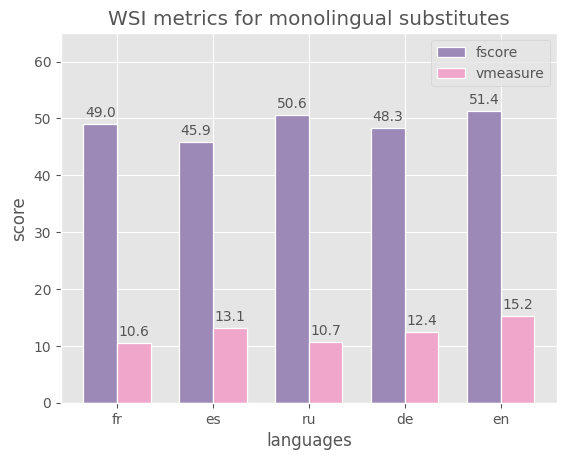

In [ ]:
fig, ax = plt.subplots()

barWidth = 0.35

r1 = np.arange(len(lang_subst.langs))
r2 = [x + barWidth for x in r1]

b1 = ax.bar(r1, lang_subst.fscore, width=barWidth, edgecolor="white", linewidth=0.9, color='#9c89b8', label='fscore')
ax.bar_label(b1, labels=lang_subst.fscore.round(1), padding=3, color='#555555')

b2 = ax.bar(r2, lang_subst.vmeasure, width=barWidth, edgecolor="white", linewidth=0.9, color='#f0a6ca', label='vmeasure')
ax.bar_label(b2, labels=lang_subst.vmeasure.round(1), padding=3, color='#555555')

ax.grid(visible=True)
ax.set_ylim(top=65)

ax.set_xlabel('languages')
ax.set_ylabel('score')
ax.set_title('WSI metrics for monolingual substitutes', fontdict={'color': '#555555'})

# Add xticks on the middle of the group bars
ax.set_xticks([r + barWidth / 2 for r in range(len(lang_subst.langs))], lang_subst.langs)
ax.legend(labelcolor='#555555')

plt.show()

In [ ]:
exp3_metrics = pd.read_csv(Path(cluter_results_folder, 'exp_lang_combinations.csv'))
exp5_metrics = pd.read_csv(Path(cluter_results_folder, 'exp_lang_combinations_no_en.csv'))
lang_combinations = pd.concat([exp3_metrics, exp5_metrics], ignore_index=True)
lang_combinations[['langs', 'n_subst', 'vectorizer', 'contextulized']] = lang_combinations['Unnamed: 0'].str.split(pat='__', expand=True)
lang_combinations['n_langs'] = lang_combinations['langs'].str.split(pat='-').apply(len)
lang_combinations.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
max_metrics_rows = lang_combinations[lang_combinations.vectorizer == 'tf-idf-weighted'].groupby(by='n_langs').idxmax()
max_metrics_rows

<ipython-input-139-571677758079>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.idxmax is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  max_metrics_rows = lang_combinations[lang_combinations.vectorizer == 'tf-idf-weighted'].groupby(by='n_langs').idxmax()


,fscore,precision,recall,vmeasure,homogenity,completeness,(fs * vm) ** 0.5
n_langs,,,,,,,
1,1,1,1,1,1,1,1
2,34,34,5,5,7,5,9
3,41,41,11,11,21,11,19
4,25,42,25,29,29,23,29
5,31,31,31,31,31,31,31


In [ ]:
fscore_max_vals = lang_combinations.loc[max_metrics_rows.fscore]['fscore'].values
fscore_max_langs = lang_combinations.loc[max_metrics_rows.fscore]['langs'].values
vmeasure_max_vals = lang_combinations.loc[max_metrics_rows.vmeasure]['vmeasure'].values
vmeasure_max_langs = lang_combinations.loc[max_metrics_rows.vmeasure]['langs'].values

Text(0.5, 1.0, 'Best language combinations for substitutes')

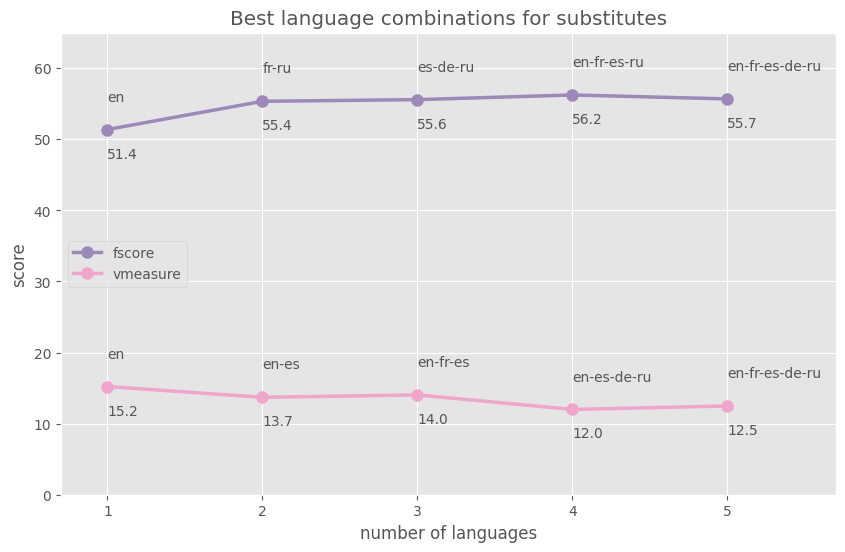

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xticks(max_metrics_rows.index)
ax.set_ylim(top=65)
ax.set_xlim(left=0.7, right=5.7)

ax.plot(max_metrics_rows.index, fscore_max_vals, marker='o', markersize=8, color='#9c89b8', label='fscore', linewidth=2.5)
for i, txt in enumerate(fscore_max_langs):
    ax.annotate(txt, (max_metrics_rows.index[i], fscore_max_vals[i] + 4), color='#555555')
    ax.annotate(fscore_max_vals[i].round(1), (max_metrics_rows.index[i], fscore_max_vals[i] - 4), color='#555555')
ax.plot(max_metrics_rows.index, vmeasure_max_vals, marker='o', markersize=8, color='#f0a6ca', label='vmeasure', linewidth=2.5)
for i, txt in enumerate(vmeasure_max_langs):
    ax.annotate(txt, (max_metrics_rows.index[i], vmeasure_max_vals[i] + 4), color='#555555')
    ax.annotate(vmeasure_max_vals[i].round(1), (max_metrics_rows.index[i], vmeasure_max_vals[i] - 4), color='#555555')

ax.set_xlabel('number of languages')
ax.set_ylabel('score')
ax.legend(labelcolor='#555555', loc='center left')
ax.set_title('Best language combinations for substitutes', fontdict={'color': '#555555'})

In [ ]:
exp2_metrics = pd.read_csv(Path(cluter_results_folder, 'exp_all_langs_n_clusters.csv'))

In [ ]:
exp2_metrics[['langs', 'n_subst', 'vectorizer', 'contextulized']] = exp2_metrics['Unnamed: 0'].str.split(pat='__', expand=True)
exp2_metrics['n_langs'] = exp2_metrics['langs'].str.split(pat='-').apply(len)
exp2_metrics.drop(columns=['Unnamed: 0'], inplace=True)
exp2_metrics

,fscore,precision,recall,vmeasure,homogenity,completeness,(fs * vm) ** 0.5,langs,n_subst,vectorizer,contextulized,n_langs
0,55.937,82.072,47.875,11.063,22.681,11.355,19.353319,en-fr-es-de-ru,5,tf-idf,dummy.json,5
1,54.963,79.546,48.158,12.053,23.061,12.646,19.983363,en-fr-es-de-ru,10,tf-idf,dummy.json,5
2,56.432,83.676,47.669,11.089,22.279,11.396,18.921604,en-fr-es-de-ru,15,tf-idf,dummy.json,5
3,56.196,83.900,47.008,9.923,21.679,10.091,17.940595,en-fr-es-de-ru,20,tf-idf,dummy.json,5
4,56.626,83.477,47.407,10.895,21.997,10.816,19.104900,en-fr-es-de-ru,25,tf-idf,dummy.json,5
5,53.109,75.311,48.048,12.420,20.819,14.444,19.181693,en-fr-es-de-ru,5,tf-idf-weighted,dummy.json,5
6,55.687,81.352,48.553,12.486,24.678,12.955,20.649188,en-fr-es-de-ru,10,tf-idf-weighted,dummy.json,5
7,56.095,83.121,47.642,10.841,22.920,11.256,19.191007,en-fr-es-de-ru,15,tf-idf-weighted,dummy.json,5
8,56.995,86.528,46.739,9.266,22.342,8.893,17.632665,en-fr-es-de-ru,20,tf-idf-weighted,dummy.json,5
9,57.478,87.508,46.974,8.843,21.840,8.419,17.192150,en-fr-es-de-ru,25,tf-idf-weighted,dummy.json,5


In [ ]:
exp2_metrics = exp2_metrics[exp2_metrics.vectorizer == 'tf-idf-weighted']
exp2_metrics

,fscore,precision,recall,vmeasure,homogenity,completeness,(fs * vm) ** 0.5,langs,n_subst,vectorizer,contextulized,n_langs
5,53.109,75.311,48.048,12.420,20.819,14.444,19.181693,en-fr-es-de-ru,5,tf-idf-weighted,dummy.json,5
6,55.687,81.352,48.553,12.486,24.678,12.955,20.649188,en-fr-es-de-ru,10,tf-idf-weighted,dummy.json,5
7,56.095,83.121,47.642,10.841,22.920,11.256,19.191007,en-fr-es-de-ru,15,tf-idf-weighted,dummy.json,5
8,56.995,86.528,46.739,9.266,22.342,8.893,17.632665,en-fr-es-de-ru,20,tf-idf-weighted,dummy.json,5
9,57.478,87.508,46.974,8.843,21.840,8.419,17.192150,en-fr-es-de-ru,25,tf-idf-weighted,dummy.json,5


Text(0.5, 0.98, 'WSI metrics and number of substitutes')

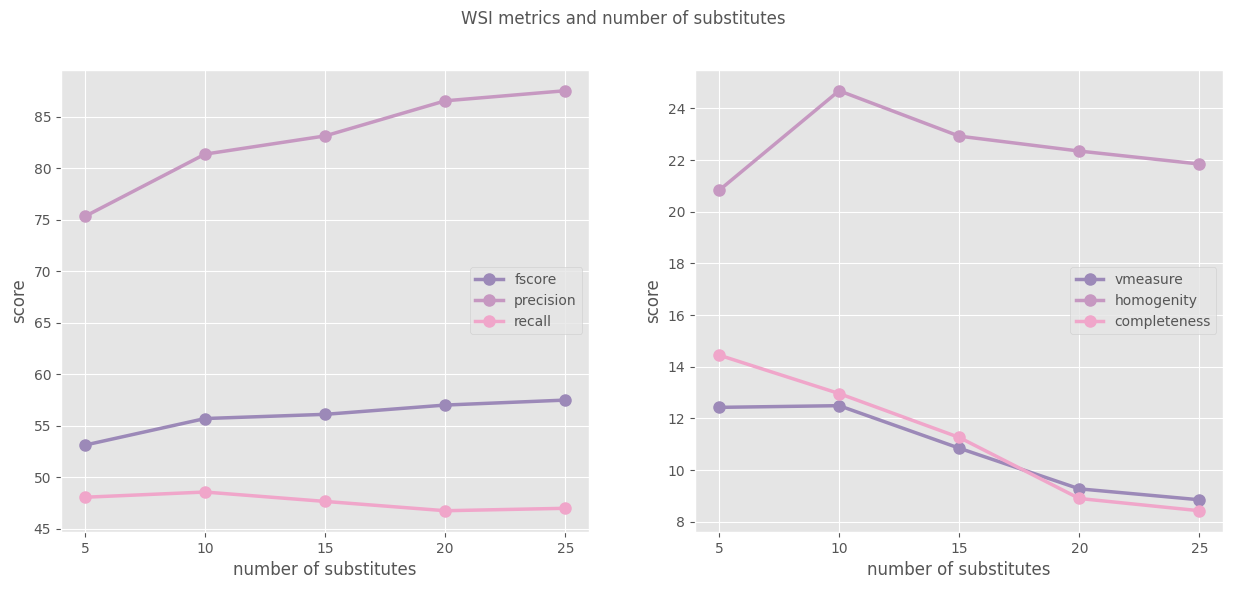

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax[0].plot(exp2_metrics.n_subst, exp2_metrics.fscore, marker='o', markersize=8, color='#9c89b8', label='fscore', linewidth=2.5)
ax[0].plot(exp2_metrics.n_subst, exp2_metrics.precision, marker='o', markersize=8, color='#c698c1', label='precision', linewidth=2.5)
ax[0].plot(exp2_metrics.n_subst, exp2_metrics.recall, marker='o', markersize=8, color='#f0a6ca', label='recall', linewidth=2.5)

ax[1].plot(exp2_metrics.n_subst, exp2_metrics.vmeasure, marker='o', markersize=8, color='#9c89b8', label='vmeasure', linewidth=2.5)
ax[1].plot(exp2_metrics.n_subst, exp2_metrics.homogenity, marker='o', markersize=8, color='#c698c1', label='homogenity', linewidth=2.5)
ax[1].plot(exp2_metrics.n_subst, exp2_metrics.completeness, marker='o', markersize=8, color='#f0a6ca', label='completeness', linewidth=2.5)

ax[0].set_xlabel('number of substitutes')
ax[1].set_xlabel('number of substitutes')
ax[0].set_ylabel('score')
ax[1].set_ylabel('score')
ax[0].legend(labelcolor='#555555', loc='center right')
ax[1].legend(labelcolor='#555555', loc='center right')
fig.suptitle('WSI metrics and number of substitutes', fontdict={'color': '#555555'})

# Иллюстрация подстановок